So far, I have been using Theano for my neural-network related projects, and I really like using it.
One drawback I found was that compilation to the target backend can take a lot of time, especially in some [cases](http://yjk21.github.io/blog/unrolling.html).
I heard that Tensorflow (TF) employs a similar paradigm as Theano, but avoids the compilation overhead by assembling pre-compiled components. 
This post contains some notes on making the transition from Theano to Tensorflow. In this first part I am setting the stage using some simple examples to get familiar with the basic API of Tensorflow.

But first things first:

In [1]:
import theano
import theano.tensor as T
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.interactive(True)

### Preliminaries

Let's start with a simple linear regression problem based on the following generative model:

A weight vector ${\bf w}$ is drawn from 
$$
P({\bf w}) = N(0, \sigma^2_p {\bf I}_D)\\
$$

Then, given ${\bf w}$ and feature vector ${\bf x}$ an observation $y$ is drawn from the likelihood:

$$
P(y \mid {\bf w}, {\bf x}) = N({\bf x}^T {\bf w}, \sigma^2_n)
$$

The hyper-parameters are assumed to be known.

With access to a data set consisting of a feature matrix ${\bf X} \in \mathbb{R}^{N \times D}$ and observations ${\bf y} \in \mathbb{R}^N$, we would like to infer the mean of the posterior distribution $P({\bf w} \mid {\bf y}, {\bf X})$ as an estimator for ${\bf w}$. 

Using [self-conjugacy](https://en.wikipedia.org/wiki/Conjugate_prior) and the coincidence of mean and mode of Gaussians we can cast posterior-mean inference into an optimization problem:

$$
{\bf\hat w} = \mathbb{E}[{\bf w} \mid {\bf y},{\bf X}] = \mathrm{arg}\min_{\bf w} E({\bf w})
$$
where the cost function is defined as

$$
E({\bf w}) :=  \Vert {\bf y} - {\bf X w} \Vert^2 + \frac{\sigma^2_n}{\sigma^2_p} \Vert {\bf w} \Vert^2
$$

which is of course just the Tikhonov-regularized least-squares objective.
Strong convexity and the well-known analytical solution for its minimizer makes it a nice test problem for our purposes. 

The code below draws a dataset from the model.
The numpy arrays here are converted to single precision ```dtype```, to be compatible with my Theano configuration, which is geared towards using GPUs.

w: [[ 0.13682203]] what: [[ 0.13519447]] error: 0.00162755613255


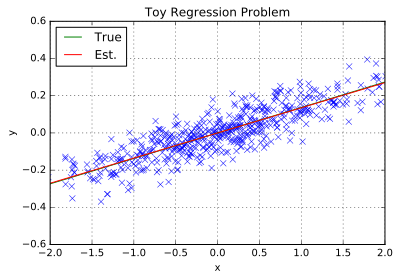

In [2]:
np.random.seed(1234)

D = 1
N = 550
s2_n = 0.005
s2_p = 0.01
l = s2_n / (N * s2_p)

X = np.random.randn(N,D).astype(np.float32)
w = np.random.randn(D,1).astype(np.float32) * np.sqrt(s2_p)
y = np.dot(X, w) + np.random.randn(N,1).astype(np.float32) * np.sqrt(s2_n)


# Analytical solution
what = np.linalg.solve(np.dot(X.T,X) + N * l * np.eye(D), np.dot(X.T, y)) 

if D == 1:
    print 'w:', w, 'what:', what, 'error:', norm(w - what)
    plt.plot(X,y, 'x')
    plt.xlabel('x')
    plt.ylabel('y')
    x = np.asmatrix([np.amin(X), np.amax(X)]).T
    z = np.dot(x, w)
    zhat = np.dot(x, what)
    p1, = plt.plot(x,z)
    p2, = plt.plot(x, zhat)

    plt.legend([p1,p2],["True", "Est."],loc=2)
    plt.grid('on')
    plt.title('Toy Regression Problem')
    plt.xlim([-2,2])

### Placeholders and Variables 
In Tensorflow, we express computations in terms symbolic quantities. There are two types, ```place_holder``` and ```Variable``` which, as far as I understand, roughly correspond to Theano's tensors and shared variables, respectively.

We will prefix Theano identifiers with ```t``` Tensorflow identifiers with ```f```.

The code below creates a function that computes $E$ and $\nabla_{\bf w} E$.

In [3]:
w0 = np.zeros((D,1)).astype(np.float32)

tX = T.matrix()
ty = T.matrix()
ts2_p = T.scalar()
ts2_n = T.scalar()
tlambda = ts2_n / (ts2_p * N)
tw = theano.shared(w0)

td = ty - T.dot(tX, tw)
tE = T.mean(td * td) + tlambda * T.sum(tw * tw)
tgE = theano.grad(tE, tw)

fnE_th = theano.function(inputs=[tX,ty,ts2_p,ts2_n], outputs=[tE, tgE])

The TF code looks quite similar, but has some subtle differences in the API. ```tf.matmul``` is very strict about dimensions and does not accept a matrix and a vector while Theano's ```dot``` is more flexible and behaves very closely to its numpy namesake.

Furthermore, placeholders can be annotated with their shape which can be valuable for catching bugs early on.

In [4]:
fX = tf.placeholder(tf.float32, [None, D])
fy = tf.placeholder(tf.float32, [None, 1])
fw = tf.Variable(w0, dtype=tf.float32,name="weights")
fl = tf.placeholder(tf.float32,shape=[])
fd = fy - tf.matmul(fX, fw)
fE = tf.reduce_mean(tf.mul(fd, fd)) + fl * tf.reduce_sum(tf.mul(fw, fw))
fgE = tf.gradients(fE, fw)

Another difference is the concept of a session that does not exist in Theano and reflects the more flexible runtime system underlying TF. 
I suppose that this additional abstraction caters to the possibility to deploy TF expressions in different environments ranging from distributed systems to mobile devices. 

The session can be easily configured, e.g. with the number of available GPUs.

In [5]:
sess = tf.Session(config=tf.ConfigProto( device_count = {'GPU': 0} ))

To evaluate expressions we can use the run method of a session. 

Variables need to be initialized by running the corresponding operation. This is necessary, because instead of specifying variables in terms of concrete data, as we did here, we could also specify it symbolically, e.g. by passing an operation that represents a random draw from some distribution. Running the variable's initializer would then perform the actual random number generation and associate the result to the variable.

The code below demonstrates initialization and evaluation of a variable using a session (certainly not the most efficient way to sample from a Gaussian :-) ). 

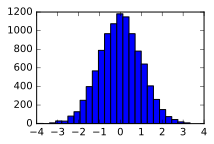

In [6]:
fv = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[]))
iv = fv.initializer
a = []
for it in xrange(10000):
    sess.run(iv)
    a.append(sess.run(fv))
plt.figure(figsize=(3,2))
plt.hist(np.array(a), bins=25);

Before proceeding, let us quickly initialize our regression weights.

In [7]:
sess.run(fw.initializer)
assert(np.all(sess.run(fw) == w0))

Placeholders on the other hand are fed to the session using the ```feed_dict``` parameter of ```Session.run()```

In [8]:
E0_tf, gE0_tf = sess.run([fE, fgE], feed_dict={fX:X, fy:y, fl:l})

Next, we make sure that the values we compute correspond to the ones computed by the Theano implementation.

In [9]:
E0_th, gE0_th = fnE_th(X,y, s2_p, s2_n)
assert(np.allclose(E0_th, E0_tf) and np.allclose(gE0_th, gE0_tf))

### Optimization

We now have everything in place to solve the optimization problem.
Here, we use gradient descent. The learning rule is implemented as show in the code below, which shows how assigments are expressed symbolically.

In [10]:
#learning rate
feta = tf.placeholder(tf.float32, shape=[])
#gradient descent update op
fupdw = fw.assign(fw - feta * fgE[0])

We can run the update for a few iterations and print some additional information to monitor the progress. 

In [11]:
sess.run(fw.initializer)
eta = 0.5
for it in xrange(10):
    E, g, ww = sess.run([fE, fgE[0], fupdw], feed_dict={fX:X, fy:y,fl:l, feta:eta})
    print "Loss E(w):", E, "\tg-norm:", norm(g, np.inf), "\twhat:", ww[0][0], "\terror:", norm(ww-what)

Loss E(w): 0.0215857 	g-norm: 0.246392 	what: 0.123196 	error: 0.0119986095555
Loss E(w): 0.00506148 	g-norm: 0.0218674 	what: 0.13413 	error: 0.00106490488125
Loss E(w): 0.00493132 	g-norm: 0.00194078 	what: 0.1351 	error: 9.45114619797e-05
Loss E(w): 0.00493029 	g-norm: 0.000172234 	what: 0.135186 	error: 8.39765144048e-06
Loss E(w): 0.00493029 	g-norm: 1.52971e-05 	what: 0.135194 	error: 7.53355748034e-07
Loss E(w): 0.00493029 	g-norm: 1.36578e-06 	what: 0.135194 	error: 6.79023331174e-08
Loss E(w): 0.00493029 	g-norm: 1.15397e-07 	what: 0.135194 	error: 8.29768834198e-09
Loss E(w): 0.00493029 	g-norm: 8.00355e-09 	what: 0.135194 	error: 8.29768834198e-09
Loss E(w): 0.00493029 	g-norm: 8.00355e-09 	what: 0.135194 	error: 8.29768834198e-09
Loss E(w): 0.00493029 	g-norm: 8.00355e-09 	what: 0.135194 	error: 8.29768834198e-09


Tensorflow already ships with a bunch of popular (and more sophisticated) optimization algorithms, which can be found in the ```train``` module. They can be used as shown below: 

In [12]:
#define a single step
fgdStep = tf.train.GradientDescentOptimizer(0.5).minimize(fE)

#re-initialize weights
sess.run(fw.initializer)

for it in xrange(10):
    sess.run(fgdStep, feed_dict={fX:X, fy:y, fl:l})
    
print norm(what - sess.run(fw))

8.29768834198e-09


### Conclusion

Tensorflow looks great. I liked that it is quite close to Theano. 
I am currently exploring the API, which is quite huge since it comes with a lot of built-in functionality, e.g. monitoring, visualizing computation graphs and support for RNNs. 
Also, there are a few new concepts, such as variable scope, that I am going to look into.